In [36]:
import geopandas as gpd
import pandas as pd
def get_path(source ,feature, mode='caminata'):
    return f'/app/data/{source}/red_escenario_futuro/{mode}/{feature}_conce'
def get_input_nodes():
    return get_path('input', 'nodes')
def get_input_edges():
    return get_path('input', 'edges')
def get_output_nodes():
    return get_path('output', 'nodes')
def get_output_edges():
    return get_path('output', 'edges')


In [37]:
edges = gpd.read_file(get_input_edges())
nodes = gpd.read_file(get_input_nodes())

In [39]:
nodes['temp_id'] = nodes.index
nodes['str_id'] = nodes['temp_id'].astype(str)
nodes.loc[nodes['osmid']==0, 'osmid'] = '992023' + nodes['str_id']
nodes.drop(columns=['temp_id', 'str_id'], inplace=True)

nodes.x = nodes.geometry.x
nodes.y = nodes.geometry.y
net_nodes = nodes.copy()
net_nodes.drop(columns=['x', 'y'], inplace=True)

In [26]:
edges_mask = edges['osmid'].astype(str).str.startswith("2023")
edges_cols = ['osmid', 'length', 'Shape_Leng', 'geometry']
new_edges = edges.loc[edges_mask, edges_cols]

<Axes: >

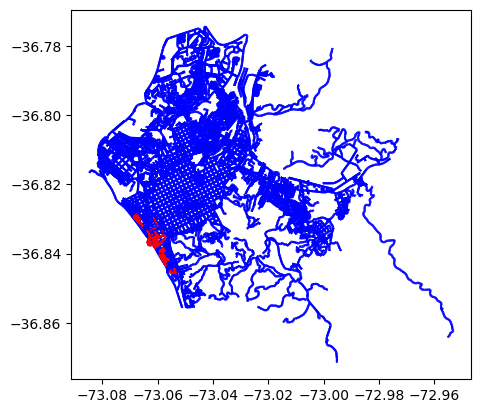

In [28]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()
edges.plot(ax=ax, color='b')
new_edges.plot(ax=ax, color='r')

In [29]:
from shapely.geometry import Point

# Suponiendo que tienes un GeoDataFrame llamado gdf
# Añade una nueva columna llamada "begin" que contiene el primer punto de cada línea
new_edges['begin'] = new_edges['geometry'].apply(lambda geom: Point(geom.coords[0]))

# Añade una nueva columna llamada "end" que contiene el último punto de cada línea
new_edges['end'] = new_edges['geometry'].apply(lambda geom: Point(geom.coords[-1]))

In [30]:
# Función para encontrar el punto más cercano en el GeoDataFrame "nodes"
def find_nearest_node(point):
    nearest = nodes['geometry'].apply(lambda x: point.distance(x)).idxmin()
    return nodes.loc[nearest, 'osmid']

# Aplicamos la función para encontrar el "source" y "destination" para cada línea en "new_edges"
new_edges['u'] = new_edges['begin'].apply(find_nearest_node)
new_edges['v'] = new_edges['end'].apply(find_nearest_node)

In [31]:
edges_cols = ['u', 'v', 'osmid', 'length', 'geometry']
old_edges = edges.loc[~edges_mask, edges_cols]
new_edges = new_edges[edges_cols]
net_edges = pd.concat([old_edges, new_edges])

In [41]:
net_nodes.to_file(get_output_nodes())
net_edges.to_file(get_output_edges())